In [1]:
import matplotlib.pyplot as plt
import torch

from botorch.models import SingleTaskGP
from gpytorch.means import ZeroMean
from gpytorch.kernels import RBFKernel

In [2]:
train_x = torch.rand(100, 1) * 3 # random in [0, 3]
train_y = torch.sin(4. * train_x) + 0.1 * torch.randn_like(train_x)

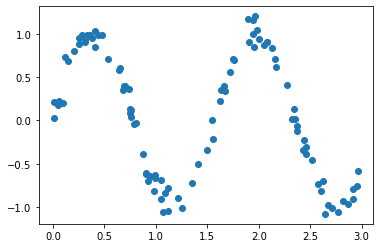

In [3]:
plt.scatter(train_x, train_y)
plt.show()

In [4]:
model = SingleTaskGP(train_x, train_y, covar_module = RBFKernel())
model.mean_module = ZeroMean()
model.likelihood.noise = 0.1
model.covar_module.lengthscale = 0.25
model.covar_module(train_x).evaluate().min()

tensor(4.0034e-31, grad_fn=<MinBackward1>)

In [5]:
test_points = torch.linspace(-0.25, 3.25, 1000).view(-1,1)

In [6]:
with torch.no_grad():
    predictions = model.posterior(test_points, observation_noise = False)

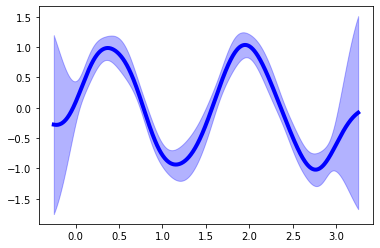

In [7]:
plt.plot(test_points, predictions.mean.detach(), color = "blue", linewidth = 4)
plt.fill_between(test_points.view(-1), *[x.detach() for x in predictions.mvn.confidence_region()], 
                 alpha = 0.3, color = "blue")
plt.show()

In [8]:
aug_policies = [0., 7, 14., 21.]

In [9]:
augmented_x = torch.cat([train_x + x for x in aug_policies])
augmented_y = torch.cat([train_y] * 4)

In [10]:
aug_model = SingleTaskGP(augmented_x, augmented_y, covar_module = RBFKernel())
aug_model.mean_module = ZeroMean()
aug_model.likelihood.noise = 0.1 * 4
aug_model.covar_module.lengthscale = 0.25


In [11]:
with torch.no_grad():
    aug_predictions = aug_model.posterior(test_points, observation_noise = False)

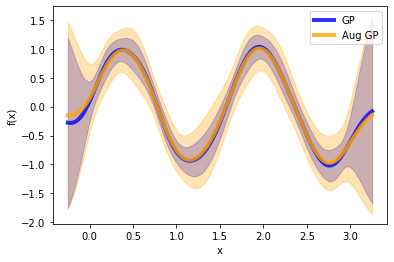

In [12]:
plt.plot(test_points, predictions.mean.detach(), color = "blue", linewidth = 4, alpha = 0.8, label = "GP")
plt.fill_between(test_points.view(-1), *[x.detach() for x in predictions.mvn.confidence_region()], 
                 alpha = 0.3, color = "blue")

plt.plot(test_points, aug_predictions.mean.detach(), color = "orange", linewidth = 4, alpha = 0.8, label = "Aug GP")
plt.fill_between(test_points.view(-1), *[x.detach() for x in aug_predictions.mvn.confidence_region()], 
                 alpha = 0.3, color = "orange")
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

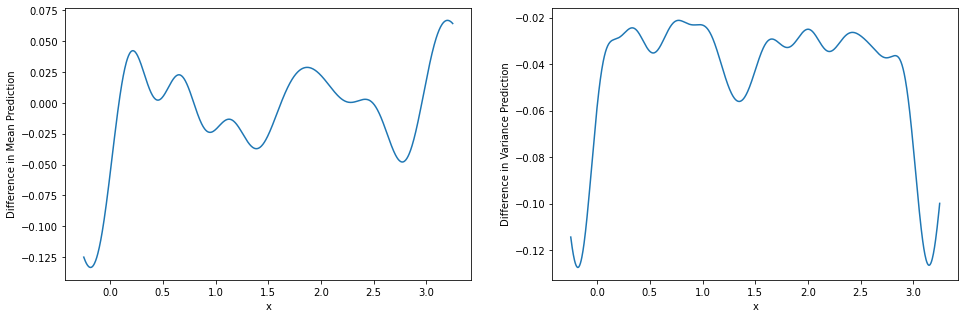

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax[0].plot(test_points, predictions.mean - aug_predictions.mean)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Difference in Mean Prediction")

ax[1].plot(test_points, predictions.variance.detach() - aug_predictions.variance.detach())
ax[1].set_xlabel("x")
ax[1].set_ylabel("Difference in Variance Prediction")

plt.show()

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import pandas as pd
from tqdm import tqdm

from palettable.cmocean.sequential import Thermal_8, Thermal_5, Thermal_6

palette = Thermal_8.mpl_colors
sns.set(style="whitegrid", font_scale=2.0, palette=Thermal_8.mpl_colors)

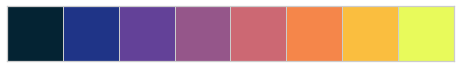

In [15]:
sns.palplot(palette)

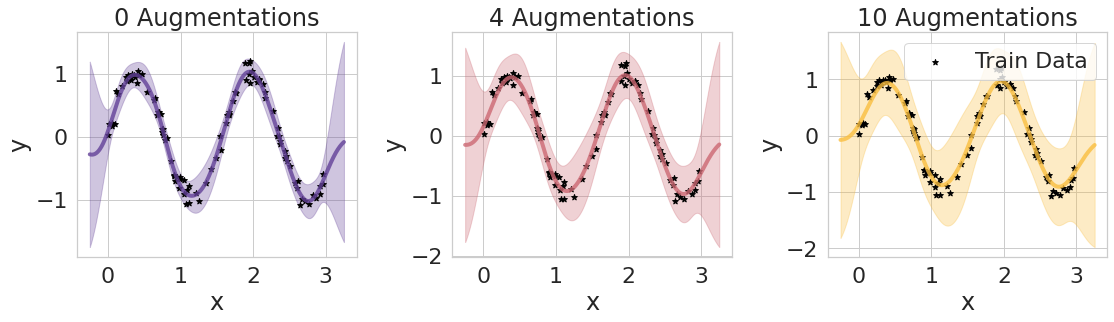

In [29]:
fig, ax = plt.subplots(1, 3, figsize = (16, 5))

ax[0].plot(test_points, predictions.mean.detach(), color = palette[2], linewidth = 4, alpha = 0.8, label = "GP")
ax[0].fill_between(test_points.view(-1), *[x.detach() for x in predictions.mvn.confidence_region()], 
                 alpha = 0.3, color = palette[2])

augmentations = [0, 4, 10]

aug_policies = [0., 7, 14., 21., 28.]
augmented_x = torch.cat([train_x + x for x in aug_policies])
augmented_y = torch.cat([train_y] * 5)
aug_model = SingleTaskGP(augmented_x, augmented_y, covar_module = RBFKernel())
aug_model.mean_module = ZeroMean()
aug_model.likelihood.noise = 0.1 * 4
aug_model.covar_module.lengthscale = 0.25

with torch.no_grad():
    aug_predictions = aug_model.posterior(test_points, observation_noise = False)

    
ax[1].plot(test_points, aug_predictions.mean.detach(), color = palette[4], linewidth = 4, alpha = 0.8, label = "Aug GP")
ax[1].fill_between(test_points.view(-1), *[x.detach() for x in aug_predictions.mvn.confidence_region()], 
                 alpha = 0.3, color = palette[4])

aug_policies = [0., 7, 14., 21., 28., 35., 42., 49., 56., 63., 70.]
augmented_x = torch.cat([train_x + x for x in aug_policies])
augmented_y = torch.cat([train_y] * 11)
aug_model = SingleTaskGP(augmented_x, augmented_y, covar_module = RBFKernel())
aug_model.mean_module = ZeroMean()
aug_model.likelihood.noise = 0.1 * 10
aug_model.covar_module.lengthscale = 0.25

with torch.no_grad():
    aug_predictions = aug_model.posterior(test_points, observation_noise = False)

    
ax[2].plot(test_points, aug_predictions.mean.detach(), color = palette[-2], linewidth = 4, alpha = 0.8,)
ax[2].fill_between(test_points.view(-1), *[x.detach() for x in aug_predictions.mvn.confidence_region()], 
                 alpha = 0.3, color = palette[-2])

for i in range(3):
    ax[i].scatter(train_x, train_y, color = "black", marker = "*", label = "Train Data")
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("y")
    ax[i].set_title(str(augmentations[i]) + " Augmentations")
    
    # now do the augmentations
    
    
plt.tight_layout()
ax[2].legend(loc = "upper right")
plt.savefig("augmentation_gp_v3.pdf", bbox_inches = "tight")